<a href="https://colab.research.google.com/github/benjamintee/CASA_DSSS/blob/main/automl/automl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mljar-supervised

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.3/127.3 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of shap to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 29.9 MB/s eta 0:00:00
  Created wheel for mljar-supervised: filename=mljar_supervised-1.

This workflow is really simple..

In [1]:
# import libraries
import pandas as pd
import numpy as np

from supervised.automl import AutoML

In [2]:
# make sure we can see the plots
%matplotlib inline

In [3]:
# mount to Google Drive so we can import the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
# read in the data wherever you stored it
# df = pd.read_csv("drive/MyDrive/urbansim/migration.csv")

In [4]:
df = pd.read_csv("https://github.com/asrenninger/urbansim/raw/main/automl/migration.csv.gz")

In [5]:
# I'm listing the columns so below I can see what I want to keep
df.columns

Index(['code_i', 'code_j', 'F_ij', 'distance', 'name_i', 'name_j', 'density_i',
       'married_i', 'households_i', 'population_i', 'nonwhite_i',
       'unhealthy_i', 'employed_i', 'university_i', 'density_j', 'married_j',
       'households_j', 'population_j', 'nonwhite_j', 'unhealthy_j',
       'employed_j', 'university_j'],
      dtype='object')

AutoML has several modes—Explain, Perform, Compete. They all use different combinations of models to create the best prediction. The lightest, fastest possible collection of models is Explain, so we will stick with that to make it run faster.

In [6]:
# create training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    # we are going to throw out the first 2 columns
    df[df.columns[3:]], df["F_ij"], test_size=0.25
)

# the results_path should point to a folder that you have already created to store the model results
automl = AutoML(results_path="drive/MyDrive/urbansim/automl", mode='Explain')
# fit the model
automl.fit(X_train, y_train)

Linear algorithm was disabled.
This model has already been fitted. You can use predict methods or select a new 'results_path' for a new 'fit()'.


See that AutoML saves the model as to your folder. Go to the directory and check out the model. There should be Feature Importance images in each model folder. These compute the "importance" of each variable by shuffling them one-by-one and seeing how much a completely random version hurts model performance. What are some important features?

In [7]:
# let's store predictions
y_pred = automl.predict(X_test)

There are lot of model evaluation metrics in [sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

In [8]:
from sklearn.metrics import mean_absolute_percentage_error, median_absolute_error, r2_score
# percent error
print(mean_absolute_percentage_error(y_test, y_pred))
# absolute error
print(median_absolute_error(y_test, y_pred))
# r-squared
print(r2_score(y_test, y_pred))

1.501019808032814
4.800205880309065
0.8067349899257537


Why do you think these are useful metrics, compared to something like RMSE?

RSME is vulnerable to large outliers because it squares the errors before averaging them, one bad prediction can blow the whole score out of proportion.



* MAPE measures error as a percentage of the actual values (Benefit of interpretabiity)
* MedAE takes the median of all absolute differences between predictions and actuals. Completely ignores outliers. If your dataset has "garbage" data points or extreme anomalies that you don't want to influence your model's grade, MedAE provides the most "typical" error. Datasets with frequent, extreme outliers where you want to know how the model performs on the "average" case.
* RMSE is scale-dependent (e.g., "450" means nothing without knowing the range). $R^2$ is usually scaled between 0 and 1. Best for: Comparing different types of models on the same problem to see which one "understands" the data's behavior better.

In [9]:
# bin the predictions so we can see which parts of the distribution we are predicting best with
y_eval = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test})
y_eval['quantile'] = pd.qcut(y_eval['y_test'], 10, duplicates='drop')
y_eval['quantile'] = y_eval['quantile'].apply(lambda x: x.mid)

/tmp/ipython-input-1186874090.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


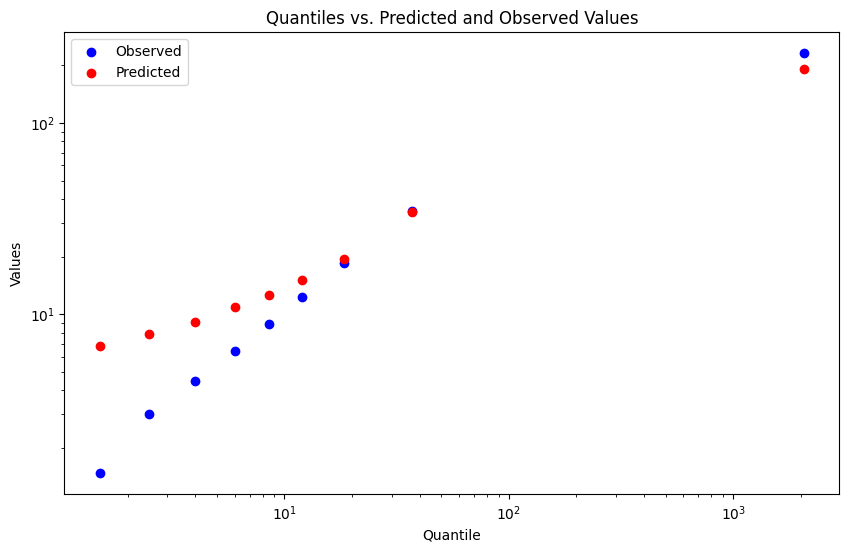

In [10]:
# average error per quantile
y_tile = y_eval.groupby('quantile', as_index=False).agg({'y_pred': 'mean', 'y_test': 'mean'})

import matplotlib.pyplot as plt
# sort the DataFrame by decile for plotting
y_tile.sort_values('quantile', inplace=True)

# create a figure and an axes instance
fig, ax = plt.subplots(figsize=(10, 6))

# scatter plot for observed values on ax
ax.scatter(y_tile['quantile'], y_tile['y_test'], color='blue', label='Observed')

# scatter plot for predicted values on ax
ax.scatter(y_tile['quantile'], y_tile['y_pred'], color='red', label='Predicted')

# adding labels and legend
ax.set_xlabel('Quantile')
ax.set_ylabel('Values')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Quantiles vs. Predicted and Observed Values')
ax.legend()

# show plot
plt.show()

It seems like we are predicting well everywhere except the low end of the distribution

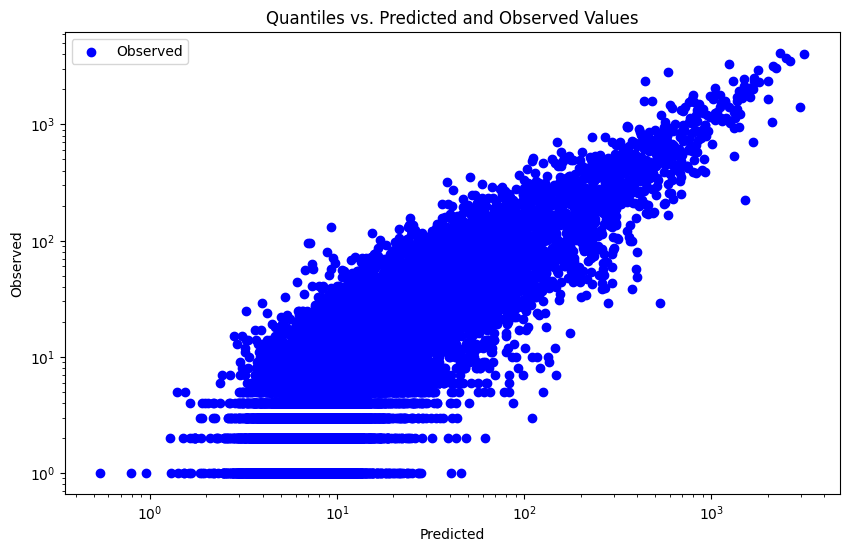

In [11]:
# predictions against observations
y_eval.sort_values('quantile', inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(y_eval['y_pred'], y_eval['y_test'], color='blue', label='Observed')
ax.set_xlabel('Predicted')
ax.set_ylabel('Observed')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Quantiles vs. Predicted and Observed Values')
ax.legend()

plt.show()

# Challenge

Create a new folder called "perform", then run AutoML again with a new results_path but instead of "Explain" use "Perform" as its mode. This will use more models in the stacking and should get better results. Show some metrics from `sklearn`and plot some results; can you show that the new "Perform" model did better or worse?

In [12]:
# the results_path should point to a folder that you have already created to store the model results
automl = AutoML(results_path="drive/MyDrive/urbansim/perform", mode='Perform')
# fit the model
automl.fit(X_train, y_train)

Linear algorithm was disabled.
This model has already been fitted. You can use predict methods or select a new 'results_path' for a new 'fit()'.


In [14]:
y_pred = automl.predict(X_test)

In [15]:
print(mean_absolute_percentage_error(y_test, y_pred))
# absolute error
print(median_absolute_error(y_test, y_pred))
# r-squared
print(r2_score(y_test, y_pred))

0.9001412415171274
3.267832877534018
0.8339874732888245


In [16]:
# bin the predictions so we can see which parts of the distribution we are predicting best with
y_eval = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test})
y_eval['quantile'] = pd.qcut(y_eval['y_test'], 10, duplicates='drop')
y_eval['quantile'] = y_eval['quantile'].apply(lambda x: x.mid)

/tmp/ipython-input-1186874090.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


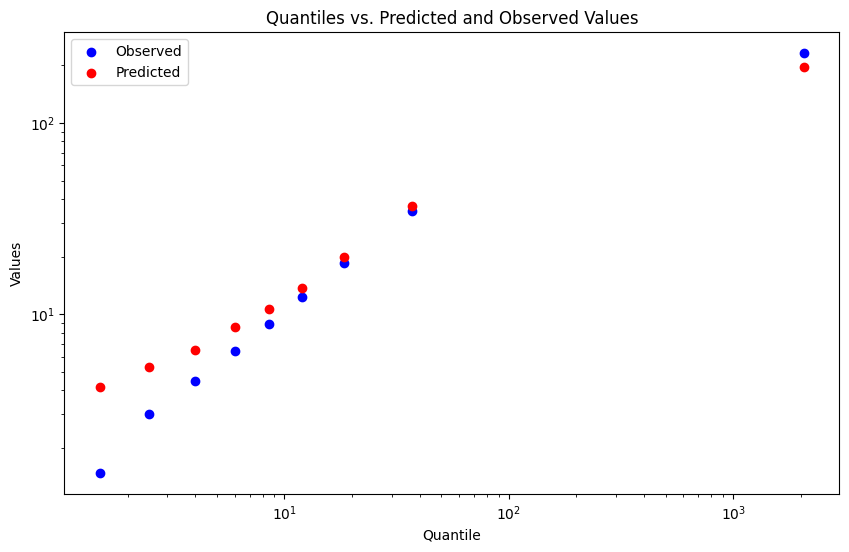

In [18]:
# average error per quantile
y_tile = y_eval.groupby('quantile', as_index=False).agg({'y_pred': 'mean', 'y_test': 'mean'})

import matplotlib.pyplot as plt
# sort the DataFrame by decile for plotting
y_tile.sort_values('quantile', inplace=True)

# create a figure and an axes instance
fig, ax = plt.subplots(figsize=(10, 6))

# scatter plot for observed values on ax
ax.scatter(y_tile['quantile'], y_tile['y_test'], color='blue', label='Observed')

# scatter plot for predicted values on ax
ax.scatter(y_tile['quantile'], y_tile['y_pred'], color='red', label='Predicted')

# adding labels and legend
ax.set_xlabel('Quantile')
ax.set_ylabel('Values')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Quantiles vs. Predicted and Observed Values')
ax.legend()

# show plot
plt.show()

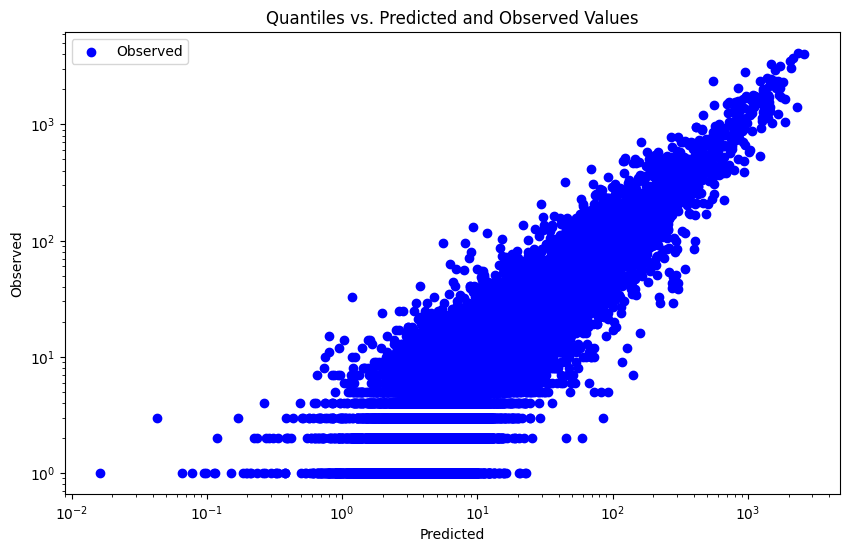

In [17]:
# predictions against observations
y_eval.sort_values('quantile', inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(y_eval['y_pred'], y_eval['y_test'], color='blue', label='Observed')
ax.set_xlabel('Predicted')
ax.set_ylabel('Observed')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Quantiles vs. Predicted and Observed Values')
ax.legend()

plt.show()